In [178]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything
from pathlib import Path
torch.set_float32_matmul_precision('high') # or'high'. This is to properly utilize Tensor Cores of my CUDA device ('NVIDIA RTX A6000')
import h5py

seed_everything(42, workers=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Seed set to 42


cuda


In [179]:
class config:
  def __init__(self):
    #The File paths
    self.data_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05' #Load data 
    self.model_path = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/ch_model_fno.pt'
    self.checkpoint_dir = 'C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/checkpoints_phase_field'

    #The training parameters
    self.num_epoch = 75
    self.batch_size = 15

    #Optimizer
    self.lr = 0.001
    self.weight_decay = 1e-4  #Regularization weight

    #The learning rate scheduler
    self.step_size = 50  #To decay after every, say 100 epochs
    self.gamma = 0.5      #To reduce the learning rate by gamma (say, 1/2)

    ##Model hyperparameters
    self.modes = 16   #Number of Fourier modes to keep
    self.fourier_channel = 64   #The input channels
    self.lift_channel = 32
    self.out_channel = 101  #We want to predict for all time evolution in a single training
    self.f_layers = 4 #Number of Fourier layers

cfg = config()

### Data Preparation

In [133]:
data_path = Path(cfg.data_path)
sorted(data_path.glob("*.mat"))

[WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_CrossShape.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_H_shape.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_HorizonBar.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_KissingBubble.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_MultiBubble.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_Square-shape.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_stripePattern.mat'),
 WindowsPath('C:/Users/idris_oduola/Documents/Projects/RqPINN/dataset/CH_dataset_T05/CH_VerticalBars.mat')]

In [134]:
d_new = []
for f in sorted(data_path.glob("*.mat")):
    with h5py.File(f, 'r') as file:
        d_new += [np.array(file['c_total']).transpose()]

In [135]:
data_ch = np.concatenate(d_new, axis=0)
data_ch.shape

(160, 100, 100, 101)

In [136]:
cfg.out_channel = data_ch.shape[-1]
cfg.out_channel

101

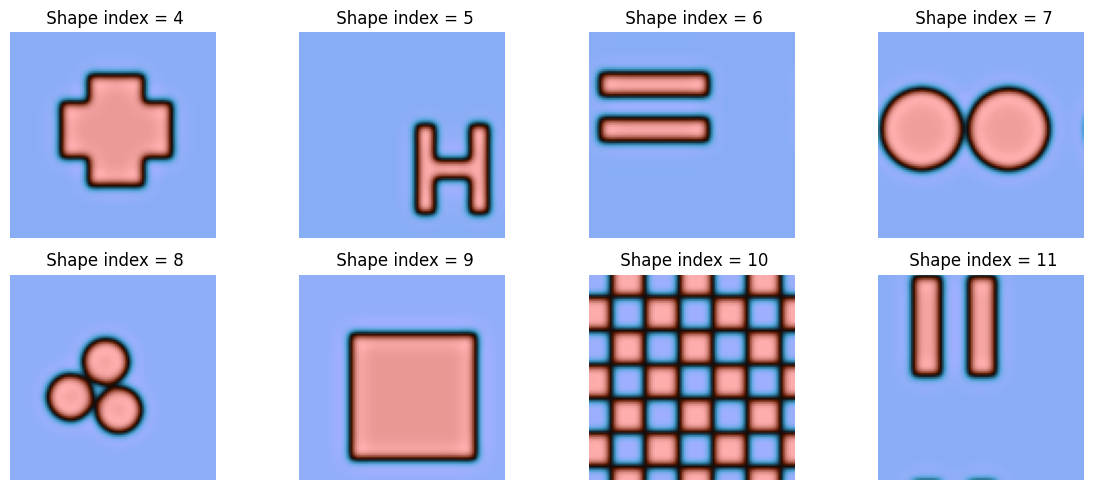

In [181]:
#Visualizing the datas
%matplotlib inline
plt.figure(figsize = (12,5))
for i in range(8):
    j = (i*20)
    dat = data_ch[j,:,:,0]
    plt.subplot(2,4,i+1)
    plt.title(f" Shape index = {i+4}")
    plt.imshow(dat, cmap='berlin', vmin=dat.min(), vmax=dat.max())
    plt.axis("off")
plt.tight_layout()
plt.show()

In [182]:
print(f"min_value = {data_ch.min()}, max_value = {data_ch.max()}")

min_value = -1.133880348974919, max_value = 1.1340860908103523


In [183]:
def input_dim(data):
    """
    A function to include the spatial dimensions as positional encoders

    """
    B,H,W = data.shape
    #The Spatial coordinates
    x_coords = torch.linspace(0,1, steps = W).view(1,-1).expand(H,W) #(100,100)
    y_coords = torch.linspace(0,1, steps = H).view(-1,1).expand(H,W) #(100,100)
    #Stacking the coordinates
    coord_stack = torch.tensor(np.stack([x_coords,y_coords], axis = -1)).float() #(100,100,2)
    coord_stack = coord_stack.unsqueeze(0) # (1,100,100,2)
    coord_stack= coord_stack.repeat(B,1,1,1)
    #Now we concatenate the data with the information on the spatial dimension
    data1 = data.unsqueeze(-1) # (B,100,100, 1)
    new_data = torch.cat([data1, coord_stack], dim = -1) # (B,100,100,3)
    assert new_data.shape[-1] == 3, print(f"Loaded input variables successfully. Data now has size {new_data.shape}")
    return new_data

In [184]:
def prepare_data(data,cfg):
    """
    Prepares the train, val and test data
    
    """

    data = torch.tensor(data).float() #Make data a torch tensor

    #Normalization
    #data = (data - data.mean())/(data.std() + 1e-8) #The small value added is to avoid division by zero
    print(f"Target is of Shape:{data.shape}")

    #Training data
    train_data = input_dim(data[:,:,:,0]) #initial concentration --> (B,100,100,3)
    print(f"Training data is of Shape:{train_data.shape}")
    training_points = data.shape[0]
    dataset = TensorDataset(train_data, data)
    train_set, val_test, test_set = random_split(dataset, [training_points - 30, 15, 15])

    #DataLoader
    train_loader = DataLoader(train_set, batch_size = cfg.batch_size, shuffle = True)
    val_loader = DataLoader(val_test, batch_size = cfg.batch_size, shuffle = False)
    test_loader = DataLoader(test_set, batch_size = cfg.batch_size, shuffle = False)

    return train_loader, val_loader, test_loader

In [185]:
class DataModule(pl.LightningDataModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.train_loader = None
        self.val_loader = None
        self.test_loader = None

    def setup(self, stage = None):
        self.train_loader, self.val_loader, self.test_loader= prepare_data(data_ch,self.cfg)
        print('DataLoaded Successfully!')

    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def test_dataloader(self):
        return self.test_loader

data_module = DataModule(cfg)
data_module.setup()

Target is of Shape:torch.Size([160, 100, 100, 101])
Training data is of Shape:torch.Size([160, 100, 100, 3])
DataLoaded Successfully!


#### Fourier Neural Operator

In [186]:
#First we define the Fourier layer 
class SpectralConv2d(nn.Module):
    def __init__(self, cfg):
        super(SpectralConv2d, self).__init__()
        self.channel_in = cfg.fourier_channel #No_of_input channels
        self.channel_out = cfg.fourier_channel
        self.modes1 = cfg.modes #Specifies how many lowest frequency to keep in the x-axis
        self.modes2 = cfg.modes #Specifies number of lowest frequencies in the y-axis
        self.scale = 1/(self.channel_in * self.channel_out) #A scaling factor to make sure the weights do not explode
        #Generate normally distributed weights R in the complex domain
        real = torch.randn(self.channel_in, self.channel_out, self.modes1, self.modes2) 
        imag = torch.randn(self.channel_in, self.channel_out, self.modes1, self.modes2)
        self.fourier_weights = nn.Parameter(
            self.scale * torch.complex(real, imag)  ##shape (channel_in, channel_out, freq_mode1, freq_mode2)

        )

    def forward(self,x):
        _,_, N1, N2 = x.shape
        
        #x.shape = (batch, channel_in, N1, N2): batch= number of samples, N1, N2 = number of spatial points in x,y coordinates
        assert x.ndim == 4, f"Input to SpectralConv2d must be of shape {x.shape}"
        #The Fast Fourier Transform
        x_ft = torch.fft.rfft2(x, dim=(-2, -1)) #shape (batch, channel_in, freq_modes1, freq_modes2)
        out_ft = torch.zeros(x.shape[0],self.channel_out,x_ft.shape[-2], x_ft.shape[-1], device = x.device, dtype = torch.cfloat) #to filter out higher modes
        out_ft[:, :, :self.modes1, :self.modes2] = torch.einsum("bixy,ioxy->boxy", x_ft[:, :, :self.modes1, :self.modes2], self.fourier_weights)
        #The inverse FFT
        x_out = torch.fft.irfft2(out_ft, s=(N1,N2), dim=(-2, -1))
        return x_out

In [187]:
#Now we define the full FNO neural operator
class FNO2d(nn.Module):
  def __init__(self, cfg):
    super(FNO2d, self).__init__()
    self.modes = cfg.modes
    self.width = cfg.fourier_channel
    self.depth = cfg.f_layers
    self.out = cfg.out_channel

    #The lifting layer: (batch, 3, N1, N2) --> (batch, width, N1, N2)
    self.lift = nn.Conv2d(in_channels = 3, out_channels = self.width, kernel_size = 1)

    #The Fourier layers
    self.spectral_layers = nn.ModuleList([SpectralConv2d(cfg) for _ in range(self.depth)])

    #Residual convolution layer
    self.w_layers = nn.ModuleList([nn.Conv2d(in_channels = self.width, out_channels = self.width, kernel_size = 1) for _ in range(self.depth)])

    #projection layer
    self.fc1 = nn.Linear(self.width, 128)
    self.fc2 = nn.Linear(128,self.out) 

  def forward(self,x):
    #x.shape = (batch, N1, N2, 3)
    x = x.permute(0,3, 1,2) # shape: (batch, N1, N2, 3) --> (batch, 3, N1, N2)
    #The lifting layer
    x = self.lift(x) # shape: (batch, 3, N1, N2) --> (batch, width, N1, N2)

    #The Fourier layers
    for spectral_layer, w_layer in zip(self.spectral_layers, self.w_layers):
      x1 = spectral_layer(x)
      x2 = w_layer(x)
      x = x1+x2
      x = F.relu(x) #Using the relu activation function

    #The projection layer
    x = x.permute(0,2,3,1) # shape: (batch, width, N1, N2)--> (batch, N1, N2, width)
    x = self.fc2(F.relu(self.fc1(x))) #shape: (batch, N1, N2, width) --> (batch, N1, N2, 101)

    return x


#### Training the FNO

In [188]:
#Initializing the model parameters
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [189]:
class PlModel(pl.LightningModule):
    def __init__(self,cfg):
        super().__init__()
        self.cfg = cfg
        self.model = FNO2d(self.cfg)
        self.model.apply(init_weights)
        self.metrics = {'train_loss':[], 'val_loss':[]}
        

    def forward(self,x):
        return self.model(x)

    def loss_function(self,y_true,y_hat, beta = 0.5):

        #A gradient loss is added to capture possible edges
        grad_true_x = y_true[:, :, 1:, :] - y_true[:, :, :-1, :]
        grad_true_y = y_true[:, 1:, :, :] - y_true[:, :-1, :, :]

        grad_pred_x = y_hat[:, :, 1:, :] - y_hat[:, :, :-1, :]
        grad_pred_y = y_hat[:, 1:, :, :] - y_hat[:, :-1, :, :]

        direct_loss = F.mse_loss(y_hat, y_true)
        return  direct_loss + beta*(F.mse_loss(grad_true_x, grad_pred_x) + F.mse_loss(grad_true_y, grad_pred_y))
        
    def _common_step(self, batch):
        x,y = batch
        y_hat = self(x)
        assert y_hat.shape == y.shape, f"Shape Mismatch! prediction shape:{y_hat.shape}, target shape: {y.shape}"
        loss = self.loss_function(y,y_hat, beta = 0.5)
        return loss

    def training_step(self, batch):
        loss = self._common_step(batch)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['train_loss'].append(loss.item())
        return loss

    def validation_step(self, batch):
        loss = self._common_step(batch)
        self.log('val_loss', loss, on_step =True, on_epoch = True, prog_bar = True, logger = True)
        self.metrics['val_loss'].append(loss.item())
        return loss

    def predict_step(self, batch):
        x,y = batch
        pred = self(x) #or self.model(x)
        return pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.cfg.lr, weight_decay = self.cfg.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = self.cfg.step_size, gamma = self.cfg.gamma)
        return [optimizer], [scheduler]



    def evaluate_on_test_set(self, loader):
        self.eval()
        losses = []; predictions = []; targets = []

        with torch.no_grad():
            for batch in loader:
                x, y = batch
                x = x.to(self.device)
                y = y.to(self.device)
                y_hat = self(x)
                predictions.append(y_hat.cpu())
                targets.append(y.cpu())

                assert y_hat.shape == y.shape, f"Prediction shape {y_hat.shape}, target shape {y.shape}"

                loss = self.loss_function(y,y_hat, beta = 0.5)
                losses.append(loss.item())

        avg_loss = sum(losses) / len(losses)
        seis_hat = torch.cat(predictions,dim =0); seis_true = torch.cat(targets,dim =0)
        print(f"Average Loss on exact test set: {avg_loss:.4f}")
        return avg_loss, seis_hat, seis_true        

In [190]:
model = PlModel(cfg)

In [191]:
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = cfg.checkpoint_dir,
    filename = 'ch_fno_d1-{epoch:02d}-{val_loss:.2f}',
    save_top_k = 1,
    mode = 'min',
    save_weights_only = True
)

trainer = pl.Trainer(
    max_epochs = cfg.num_epoch,
    callbacks = [checkpoint_callback],
    accelerator = 'gpu',
    devices = 1,
    enable_progress_bar = True,
    log_every_n_steps = 20,
    deterministic = True
)

#Train the model
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\idris_oduola\Documents\Projects\RqPINN\dataset\checkpoints_phase_field exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | model | FNO2d | 4.2 M  | train
----------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.930    Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Target is of Shape:torch.Size([160, 100, 100, 101])
Training data is of Shape:torch.Size([160, 100, 100, 3])
DataLoaded Successfully!


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
c:\Users\idris_oduola\Documents\Projects\RqPINN\venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


#### Evaluation

In [196]:
checkpoint_path = sorted(Path(cfg.checkpoint_dir).glob("ch_fno_d1-*.ckpt"))[-1]
model = PlModel.load_from_checkpoint(
    checkpoint_path,
    cfg=cfg 
)

pred_loader = data_module.test_dataloader()

In [197]:
batch = next(iter(data_module.test_dataloader()))
w_init, w_fin = batch
print("Initial Vorticity batch shape:", w_init.shape)
print("Final Vorticities batch shape:", w_fin.shape)

print(w_init.max(), w_init.min())
print(w_fin.max(), w_fin.min())

Initial Vorticity batch shape: torch.Size([15, 100, 100, 3])
Final Vorticities batch shape: torch.Size([15, 100, 100, 101])
tensor(1.1215) tensor(-1.0933)
tensor(1.1215) tensor(-1.0933)


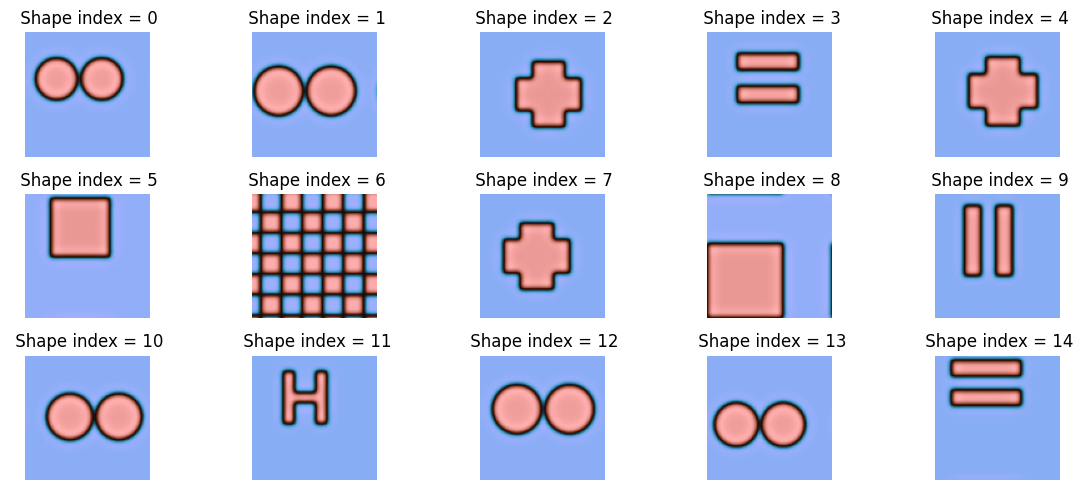

In [198]:
#Visualizing the datas
%matplotlib inline
plt.figure(figsize = (12,5))
for i in range(15):
    dat = w_init[i,:,:,0]
    plt.subplot(3,5,i+1)
    plt.title(f" Shape index = {i}")
    plt.imshow(dat, cmap='berlin', vmin=dat.min(), vmax=dat.max())
    plt.axis("off")
plt.tight_layout()
plt.show()

In [201]:
avgloss, preds, exact = model.evaluate_on_test_set(pred_loader)
preds = preds.permute(0,3,1,2)
exact = exact.permute(0,3,1,2)

Average Loss on exact test set: 0.0866


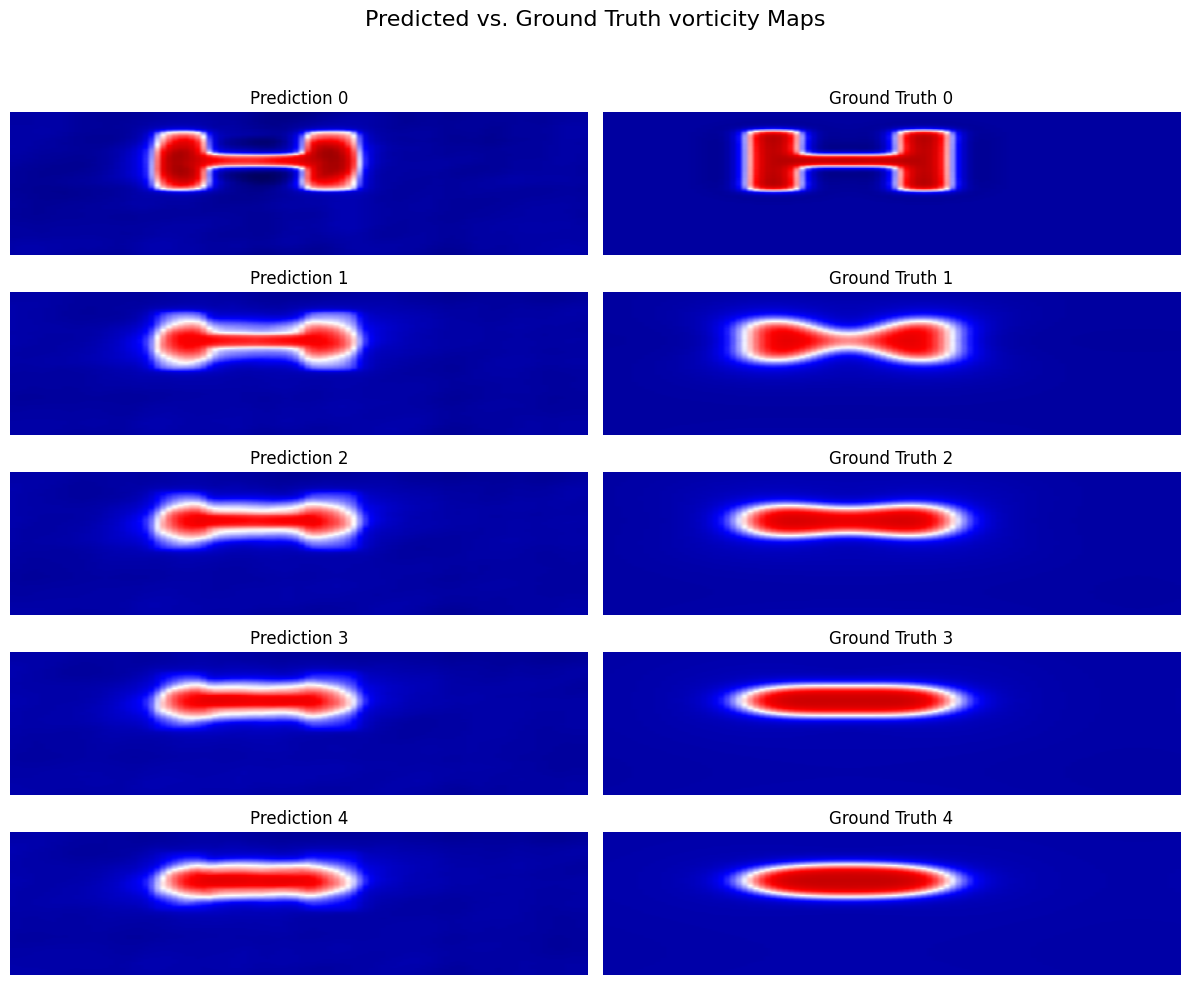

In [220]:
%matplotlib inline
plt.figure(figsize=(12, 10))
plt.suptitle("Predicted vs. Ground Truth vorticity Maps", fontsize=16)
n = 11
vmin = min(preds.min(), exact.min()).item()
vmax = max(preds.max(), exact.max()).item()
for i in range(5):  # Plot 5 samples: pred + target
    # Plot prediction
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(preds[n, i, :, :], aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
    plt.title(f"Prediction {i}")
    plt.axis("off")

    # Plot corresponding ground truth
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(exact[n, i, :, :], aspect='auto', cmap='seismic', vmin=vmin, vmax=vmax)
    plt.title(f"Ground Truth {i}")
    plt.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


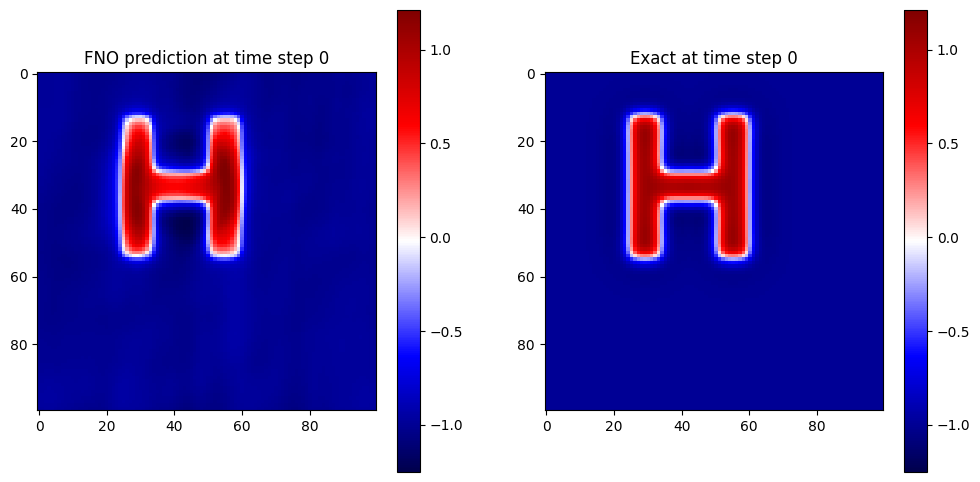

In [221]:
from matplotlib.animation import FuncAnimation

sample_idx = 11
u_pred = preds[sample_idx]    # Shape: (T, H, W)
u_exact = exact[sample_idx]   # Shape: (T, H, W)

T = u_pred.shape[0]

# Set up side-by-side plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
vmin = min(u_pred.min(), u_exact.min()).item()
vmax = max(u_pred.max(), u_exact.max()).item()

im_pred = axs[0].imshow(u_pred[0], cmap='seismic', vmin=vmin, vmax=vmax)
im_exact = axs[1].imshow(u_exact[0], cmap='seismic', vmin=vmin, vmax=vmax)

axs[0].set_title("Prediction at time step 0")
axs[1].set_title("Exact at time step 0")

fig.colorbar(im_pred, ax=axs[0])
fig.colorbar(im_exact, ax=axs[1])

def update(i):
    im_pred.set_data(u_pred[i])
    im_exact.set_data(u_exact[i])
    axs[0].set_title(f"FNO prediction at time step {i}")
    axs[1].set_title(f"Exact at time step {i}")
    return [im_pred, im_exact]

# Create animation
ani = FuncAnimation(fig, update, frames=T, interval=100)

# Save as GIF
ani.save('H_shape.gif', writer='pillow', fps=10)


In [ ]:
#Animated Visualization for a sample in time
%matplotlib qt

sample_idx = 6

u_pred = preds[sample_idx]    # Shape: (100, H, W)
u_exact = exact[sample_idx]   # Shape: (100, H, W)

vmin = min(u_pred.min(), u_exact.min()).item()
vmax = max(u_pred.max(), u_exact.max()).item()

# side-by-side figure setup
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
im_pred = axs[0].imshow(u_pred[0], cmap='seismic', vmin=vmin, vmax=vmax)
im_exact = axs[1].imshow(u_exact[0], cmap='seismic', vmin=vmin, vmax=vmax)

axs[0].set_title("Prediction at time step 0")
axs[1].set_title("Exact at time step 0")

fig.colorbar(im_pred, ax=axs[0])
fig.colorbar(im_exact, ax=axs[1])

# Animation loop
for i in range(u_pred.shape[0]):
    im_pred.set_data(u_pred[i])
    im_exact.set_data(u_exact[i])
    axs[0].set_title(f"Prediction at time step {i}")
    axs[1].set_title(f"Exact at time step {i}")
    plt.pause(0.1)

plt.show()
